In [1]:
import pandas as pd
import numpy as np
import pandas_datareader.data as web
 
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
%matplotlib inline
sns.set_style('whitegrid')

In [2]:
indicators = {
'JHDUSRGDPBR':'Recession_GDP', 
'USREC': 'Recession_NBER',
'T10Y3M': 'Yield_Spread_10Y3M', 
'T10Y2Y': 'Yield_Spread_10Y2Y', 
'CPIAUCSL': 'CPI', 
'CPILFESL': 'Core_CPI',
'PPIACO': 'PPI',
'PCE': 'PCE', # Personal Consumption Expenditures
'DPCCRC1M027SBEA': 'Core_PCE', # Personal consumption expenditures excluding food and energy
'DCOILWTICO': 'WTI',
'UNRATE': 'Unemployment_Rate',
'NROU': 'Natural_Unemployment_Rate',
'HOUST' : 'New_Housing_Units',
'CSUSHPINSA': 'Case_Shiller',
'NFCI': 'NFCI', 
'NFCINONFINLEVERAGE': 'NFCI_Leverage', 
'UMCSENT': 'UMC_Sentiment'
}
 
data = web.DataReader(indicators.keys(), 'fred', '18540101', '20221031')
data = data.rename(columns=indicators)
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 14000 entries, 1854-12-01 to 2022-10-31
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Recession_GDP              219 non-null    float64
 1   Recession_NBER             2015 non-null   float64
 2   Yield_Spread_10Y3M         10211 non-null  float64
 3   Yield_Spread_10Y2Y         11602 non-null  float64
 4   CPI                        910 non-null    float64
 5   Core_CPI                   790 non-null    float64
 6   PPI                        1318 non-null   float64
 7   PCE                        766 non-null    float64
 8   Core_PCE                   766 non-null    float64
 9   WTI                        9281 non-null   float64
 10  Unemployment_Rate          898 non-null    float64
 11  Natural_Unemployment_Rate  296 non-null    float64
 12  New_Housing_Units          766 non-null    float64
 13  Case_Shiller               42

In [3]:
df_st_dt = pd.DataFrame.from_dict(
    {col: [data[col].dropna().index[0].strftime('%Y%m%d')] for col in indicators.values()}, 
    orient='index', 
    columns=['START_DATE']).sort_values('START_DATE')
 
df_end_dt = pd.DataFrame.from_dict(
    {col: [data[col].dropna().index[-1].strftime('%Y%m%d')] for col in indicators.values()}, 
    orient='index', 
    columns=['END_DATE']).sort_values('END_DATE')
                                    
pd.concat([df_st_dt, df_end_dt], axis=1)

,START_DATE,END_DATE
Recession_NBER,18541201,20221001
PPI,19130101,20221001
CPI,19470101,20221001
Unemployment_Rate,19480101,20221001
Natural_Unemployment_Rate,19490101,20221001
UMC_Sentiment,19521101,20221001
Core_CPI,19570101,20221001
New_Housing_Units,19590101,20221001
Core_PCE,19590101,20221001
PCE,19590101,20221001


In [4]:
#### 경기침체 여부 NBER
data.Recession_NBER.dropna() # 월 1회 산출

DATE
1854-12-01    1.0
1855-01-01    0.0
1855-02-01    0.0
1855-03-01    0.0
1855-04-01    0.0
             ... 
2022-06-01    0.0
2022-07-01    0.0
2022-08-01    0.0
2022-09-01    0.0
2022-10-01    0.0
Name: Recession_NBER, Length: 2015, dtype: float64

In [5]:
#### 경기침체 여부 GDP based
data.Recession_GDP.dropna() # 분기 1회 산출 - 1월,4월,7월,10월

DATE
1967-10-01    0.0
1968-01-01    0.0
1968-04-01    0.0
1968-07-01    0.0
1968-10-01    0.0
             ... 
2021-04-01    0.0
2021-07-01    0.0
2021-10-01    0.0
2022-01-01    0.0
2022-04-01    0.0
Name: Recession_GDP, Length: 219, dtype: float64

In [6]:
df_rec = data[['Recession_NBER']].dropna()
df_rec['Recession_NBER_shift'] = df_rec['Recession_NBER'].shift(1)
df_rec = df_rec.dropna()
df_rec = df_rec.iloc[1:]
df_rec_nber = pd.concat([pd.Series(df_rec[(df_rec.Recession_NBER==1) & 
                                            (df_rec.Recession_NBER_shift==0)].index, name='START_DATE'),
                        pd.Series(df_rec[(df_rec.Recession_NBER==0) & 
                                            (df_rec.Recession_NBER_shift==1)].index, name='END_DATE')], 
                                            axis=1)
 
df_rec = data[['Recession_GDP']].dropna()
df_rec['Recession_GDP_shift'] = df_rec['Recession_GDP'].shift(1)
df_rec = df_rec.dropna()
df_rec = df_rec.iloc[1:]
df_rec_gdp = pd.concat([pd.Series(df_rec[(df_rec.Recession_GDP==1) & 
                                            (df_rec.Recession_GDP_shift==0)].index, name='START_DATE'),
                        pd.Series(df_rec[(df_rec.Recession_GDP==0) & 
                                            (df_rec.Recession_GDP_shift==1)].index, name='END_DATE')], 
                                            axis=1)
                                            
df_rec_nber = df_rec_nber[df_rec_nber.START_DATE>='19671001'].reset_index(drop=True)
df_rec_nber['DIFF_DATE'] = pd.to_datetime(df_rec_nber['END_DATE'])-pd.to_datetime(df_rec_nber['START_DATE'])
df_rec_gdp['DIFF_DATE'] = pd.to_datetime(df_rec_gdp['END_DATE'])-pd.to_datetime(df_rec_gdp['START_DATE'])
 

In [7]:
df_rec_nber

,START_DATE,END_DATE,DIFF_DATE
0,1970-01-01,1970-12-01,334 days
1,1973-12-01,1975-04-01,486 days
2,1980-02-01,1980-08-01,182 days
3,1981-08-01,1982-12-01,487 days
4,1990-08-01,1991-04-01,243 days
5,2001-04-01,2001-12-01,244 days
6,2008-01-01,2009-07-01,547 days
7,2020-03-01,2020-05-01,61 days


In [8]:
df_rec_gdp

,START_DATE,END_DATE,DIFF_DATE
0,1969-04-01,1971-01-01,640 days
1,1973-10-01,1975-04-01,547 days
2,1979-04-01,1980-07-01,457 days
3,1981-04-01,1982-07-01,456 days
4,1989-10-01,1991-04-01,547 days
5,2001-01-01,2001-10-01,273 days
6,2007-10-01,2009-07-01,639 days
7,2020-01-01,2020-07-01,182 days


In [9]:
#### 장단기 금리 스프레드 10년 - 3개월
data.Yield_Spread_10Y3M.dropna() # 매영업일 마다 산출

DATE
1982-01-04    2.32
1982-01-05    2.24
1982-01-06    2.43
1982-01-07    2.46
1982-01-08    2.50
              ... 
2022-10-25   -0.04
2022-10-26   -0.07
2022-10-27   -0.17
2022-10-28   -0.16
2022-10-31   -0.12
Name: Yield_Spread_10Y3M, Length: 10211, dtype: float64

In [10]:
#### 장단기 금리 스프레드 10년 - 2년
data.Yield_Spread_10Y2Y.dropna() # 매영업일 마다 산출

DATE
1976-06-01    0.68
1976-06-02    0.71
1976-06-03    0.70
1976-06-04    0.77
1976-06-07    0.79
              ... 
2022-10-25   -0.32
2022-10-26   -0.35
2022-10-27   -0.34
2022-10-28   -0.39
2022-10-31   -0.41
Name: Yield_Spread_10Y2Y, Length: 11602, dtype: float64

### 물가 관련 지표

In [11]:
#### CPI
data.CPI.dropna() # 월 1회

DATE
1947-01-01     21.480
1947-02-01     21.620
1947-03-01     22.000
1947-04-01     22.000
1947-05-01     21.950
               ...   
2022-06-01    295.328
2022-07-01    295.271
2022-08-01    295.620
2022-09-01    296.761
2022-10-01    298.062
Name: CPI, Length: 910, dtype: float64

In [12]:
#### Core CPI
data.Core_CPI.dropna() # 월 1회

DATE
1957-01-01     28.500
1957-02-01     28.600
1957-03-01     28.700
1957-04-01     28.800
1957-05-01     28.800
               ...   
2022-06-01    294.354
2022-07-01    295.275
2022-08-01    296.950
2022-09-01    298.660
2022-10-01    299.471
Name: Core_CPI, Length: 790, dtype: float64

In [13]:
#### PPI
data.PPI.dropna() # 월 1회

DATE
1913-01-01     12.100
1913-02-01     12.000
1913-03-01     12.000
1913-04-01     12.000
1913-05-01     11.900
               ...   
2022-06-01    280.251
2022-07-01    272.274
2022-08-01    269.557
2022-09-01    268.085
2022-10-01    265.139
Name: PPI, Length: 1318, dtype: float64

In [14]:
#### PCE
data.PCE.dropna() # 월 1회

DATE
1959-01-01      306.1
1959-02-01      309.6
1959-03-01      312.7
1959-04-01      312.2
1959-05-01      316.1
               ...   
2022-06-01    17437.4
2022-07-01    17405.0
2022-08-01    17518.2
2022-09-01    17628.2
2022-10-01    17776.1
Name: PCE, Length: 766, dtype: float64

In [15]:
#### Core PCE
data.Core_PCE.dropna() # 월 1회

DATE
1959-01-01      221.7
1959-02-01      225.5
1959-03-01      229.6
1959-04-01      229.3
1959-05-01      231.8
               ...   
2022-06-01    15274.0
2022-07-01    15295.6
2022-08-01    15435.9
2022-09-01    15549.3
2022-10-01    15666.5
Name: Core_PCE, Length: 766, dtype: float64

In [16]:
#### WTI
data.WTI.dropna() # 일별

DATE
1986-01-02    25.56
1986-01-03    26.00
1986-01-06    26.53
1986-01-07    25.85
1986-01-08    25.87
              ...  
2022-10-25    86.93
2022-10-26    89.39
2022-10-27    89.06
2022-10-28    87.85
2022-10-31    86.54
Name: WTI, Length: 9281, dtype: float64

### 실업률 지표

In [17]:
#### Unemployment Rate
data.Unemployment_Rate.dropna() # 월 1회

DATE
1948-01-01    3.4
1948-02-01    3.8
1948-03-01    4.0
1948-04-01    3.9
1948-05-01    3.5
             ... 
2022-06-01    3.6
2022-07-01    3.5
2022-08-01    3.7
2022-09-01    3.5
2022-10-01    3.7
Name: Unemployment_Rate, Length: 898, dtype: float64

In [18]:
#### Natural Unemployment Rate
data.Natural_Unemployment_Rate.dropna() # 분기 1회

DATE
1949-01-01    5.255053
1949-04-01    5.261516
1949-07-01    5.268013
1949-10-01    5.274564
1950-01-01    5.281182
                ...   
2021-10-01    4.450651
2022-01-01    4.445137
2022-04-01    4.440214
2022-07-01    4.435784
2022-10-01    4.431760
Name: Natural_Unemployment_Rate, Length: 296, dtype: float64

### 주택관련 지표

In [19]:
#### 신규주택 착공건수
data.New_Housing_Units.dropna() # 월 1회 산출

DATE
1959-01-01    1657.0
1959-02-01    1667.0
1959-03-01    1620.0
1959-04-01    1590.0
1959-05-01    1498.0
               ...  
2022-06-01    1575.0
2022-07-01    1377.0
2022-08-01    1508.0
2022-09-01    1488.0
2022-10-01    1425.0
Name: New_Housing_Units, Length: 766, dtype: float64

In [20]:
#### Case Shiler 주택가격지수
data.Case_Shiller.dropna() # 월 1회 산출

DATE
1987-01-01     63.734
1987-02-01     64.134
1987-03-01     64.470
1987-04-01     64.974
1987-05-01     65.548
               ...   
2022-05-01    306.605
2022-06-01    308.422
2022-07-01    307.001
2022-08-01    303.472
2022-09-01    300.412
Name: Case_Shiller, Length: 429, dtype: float64

### 기타 지표

In [21]:
#### 시카고 연준 금융 상황 지수
data.NFCI.dropna() # 주 1회 산출

DATE
1971-01-08    0.56137
1971-01-15    0.60987
1971-01-22    0.66888
1971-01-29    0.73282
1971-02-05    0.79737
               ...   
2022-09-30   -0.03843
2022-10-07   -0.02873
2022-10-14   -0.03074
2022-10-21   -0.05380
2022-10-28   -0.08303
Name: NFCI, Length: 2704, dtype: float64

In [22]:
#### NFCI 비금융 레버리지 서브인덱스
data.NFCI_Leverage.dropna() # 주 1회 산출

DATE
1971-01-08   -0.70520
1971-01-15   -0.71249
1971-01-22   -0.72137
1971-01-29   -0.73199
1971-02-05   -0.74445
               ...   
2022-09-30   -1.06779
2022-10-07   -1.05960
2022-10-14   -1.05173
2022-10-21   -1.04411
2022-10-28   -1.03665
Name: NFCI_Leverage, Length: 2704, dtype: float64

In [23]:
#### 미시간 대학교 소비자 심리지수
data.UMC_Sentiment.dropna() # 월 1회 산출

DATE
1952-11-01    86.2
1953-02-01    90.7
1953-08-01    80.8
1953-11-01    80.7
1954-02-01    82.0
              ... 
2022-06-01    50.0
2022-07-01    51.5
2022-08-01    58.2
2022-09-01    58.6
2022-10-01    59.9
Name: UMC_Sentiment, Length: 630, dtype: float64

## 데이터 전처리

In [24]:
#월 단위로 데이터 리샘플링
data_resampled = data.ffill().resample('M').last()
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2015 entries, 1854-12-31 to 2022-10-31
Freq: M
Data columns (total 17 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Recession_GDP              661 non-null    float64
 1   Recession_NBER             2015 non-null   float64
 2   Yield_Spread_10Y3M         490 non-null    float64
 3   Yield_Spread_10Y2Y         557 non-null    float64
 4   CPI                        910 non-null    float64
 5   Core_CPI                   790 non-null    float64
 6   PPI                        1318 non-null   float64
 7   PCE                        766 non-null    float64
 8   Core_PCE                   766 non-null    float64
 9   WTI                        442 non-null    float64
 10  Unemployment_Rate          898 non-null    float64
 11  Natural_Unemployment_Rate  886 non-null    float64
 12  New_Housing_Units          766 non-null    float64
 13  Case_Shiller          

In [25]:
#전년 동기대비(YoY), 전반기 대비(HoH), 전분기 대비(QoQ), 전월 대비(MoM) 증감률을 계산
data_resampled = data_resampled.assign(
 
    CPI_YoY=data_resampled.CPI.pct_change(12),
    Core_CPI_YoY=data_resampled.Core_CPI.pct_change(12),
    PPI_YoY=data_resampled.PPI.pct_change(12),
    PCE_YoY=data_resampled.PCE.pct_change(12),
    Core_PCE_YoY=data_resampled.Core_PCE.pct_change(12),
    WTI_YoY=data_resampled.WTI.pct_change(12),
    Unemployment_Rate_YoY=data_resampled.Unemployment_Rate.pct_change(12),
    Natural_Unemployment_Rate_YoY=data_resampled.Natural_Unemployment_Rate.pct_change(12),
    New_Housing_Units_YoY=data_resampled.New_Housing_Units.pct_change(12),
    Case_Shiller_YoY=data_resampled.Case_Shiller.pct_change(12),
    UMC_Sentiment_YoY=data_resampled.UMC_Sentiment.pct_change(12),
 
    CPI_HoH=data_resampled.CPI.pct_change(6),
    Core_CPI_HoH=data_resampled.Core_CPI.pct_change(6),
    PPI_HoH=data_resampled.PPI.pct_change(6),
    PCE_HoH=data_resampled.PCE.pct_change(6),
    Core_PCE_HoH=data_resampled.Core_PCE.pct_change(6),
    WTI_HoH=data_resampled.WTI.pct_change(6),
    Unemployment_Rate_HoH=data_resampled.Unemployment_Rate.pct_change(6),
    Natural_Unemployment_Rate_HoH=data_resampled.Natural_Unemployment_Rate.pct_change(6),
    New_Housing_Units_HoH=data_resampled.New_Housing_Units.pct_change(6),
    Case_Shiller_HoH=data_resampled.Case_Shiller.pct_change(6),
    UMC_Sentiment_HoH=data_resampled.UMC_Sentiment.pct_change(6),
 
    CPI_QoQ=data_resampled.CPI.pct_change(3),
    Core_CPI_QoQ=data_resampled.Core_CPI.pct_change(3),
    PPI_QoQ=data_resampled.PPI.pct_change(3),
    PCE_QoQ=data_resampled.PCE.pct_change(3),
    Core_PCE_QoQ=data_resampled.Core_PCE.pct_change(3),
    WTI_QoQ=data_resampled.WTI.pct_change(3),
    Unemployment_Rate_QoQ=data_resampled.Unemployment_Rate.pct_change(3),
    Natural_Unemployment_Rate_QoQ=data_resampled.Natural_Unemployment_Rate.pct_change(3),
    New_Housing_Units_QoQ=data_resampled.New_Housing_Units.pct_change(3),
    Case_Shiller_QoQ=data_resampled.Case_Shiller.pct_change(3),
    UMC_Sentiment_QoQ=data_resampled.UMC_Sentiment.pct_change(3),
 
    CPI_MoM=data_resampled.CPI.pct_change(1),
    Core_CPI_MoM=data_resampled.Core_CPI.pct_change(1),
    PPI_MoM=data_resampled.PPI.pct_change(1),
    PCE_MoM=data_resampled.PCE.pct_change(1),
    Core_PCE_MoM=data_resampled.Core_PCE.pct_change(1),
    WTI_MoM=data_resampled.WTI.pct_change(1),
    Unemployment_Rate_MoM=data_resampled.Unemployment_Rate.pct_change(1),
    Natural_Unemployment_Rate_MoM=data_resampled.Natural_Unemployment_Rate.pct_change(1),
    New_Housing_Units_MoM=data_resampled.New_Housing_Units.pct_change(1),
    Case_Shiller_MoM=data_resampled.Case_Shiller.pct_change(1),
    UMC_Sentiment_MoM=data_resampled.UMC_Sentiment.pct_change(1)
                                       )

In [26]:
data_resampled = data_resampled.dropna()
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 418 entries, 1988-01-31 to 2022-10-31
Freq: M
Data columns (total 61 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Recession_GDP                  418 non-null    float64
 1   Recession_NBER                 418 non-null    float64
 2   Yield_Spread_10Y3M             418 non-null    float64
 3   Yield_Spread_10Y2Y             418 non-null    float64
 4   CPI                            418 non-null    float64
 5   Core_CPI                       418 non-null    float64
 6   PPI                            418 non-null    float64
 7   PCE                            418 non-null    float64
 8   Core_PCE                       418 non-null    float64
 9   WTI                            418 non-null    float64
 10  Unemployment_Rate              418 non-null    float64
 11  Natural_Unemployment_Rate      418 non-null    float64
 12  New_Housing_Units      

In [27]:
label='Recession_NBER'
label_drop = 'Recession_GDP'
features = [col for col in data_resampled if col not in [label, label_drop]]
 
pct_cols = ['CPI', 'Core_CPI', 'PPI', 'PCE', 'Core_PCE', 'WTI', 'Unemployment_Rate', 'Natural_Unemployment_Rate', 'New_Housing_Units', 'Case_Shiller', 'UMC_Sentiment']
non_pct_cols = ['Yield_Spread_10Y3M', 'Yield_Spread_10Y2Y', 'NFCI', 'NFCI_Leverage']
 
features_org = pct_cols + non_pct_cols
features_YoY = [f'{col}_YoY' for col in pct_cols] + non_pct_cols
features_HoH = [f'{col}_HoH' for col in pct_cols] + non_pct_cols
features_QoQ = [f'{col}_QoQ' for col in pct_cols] + non_pct_cols
features_MoM = [f'{col}_MoM' for col in pct_cols] + non_pct_cols

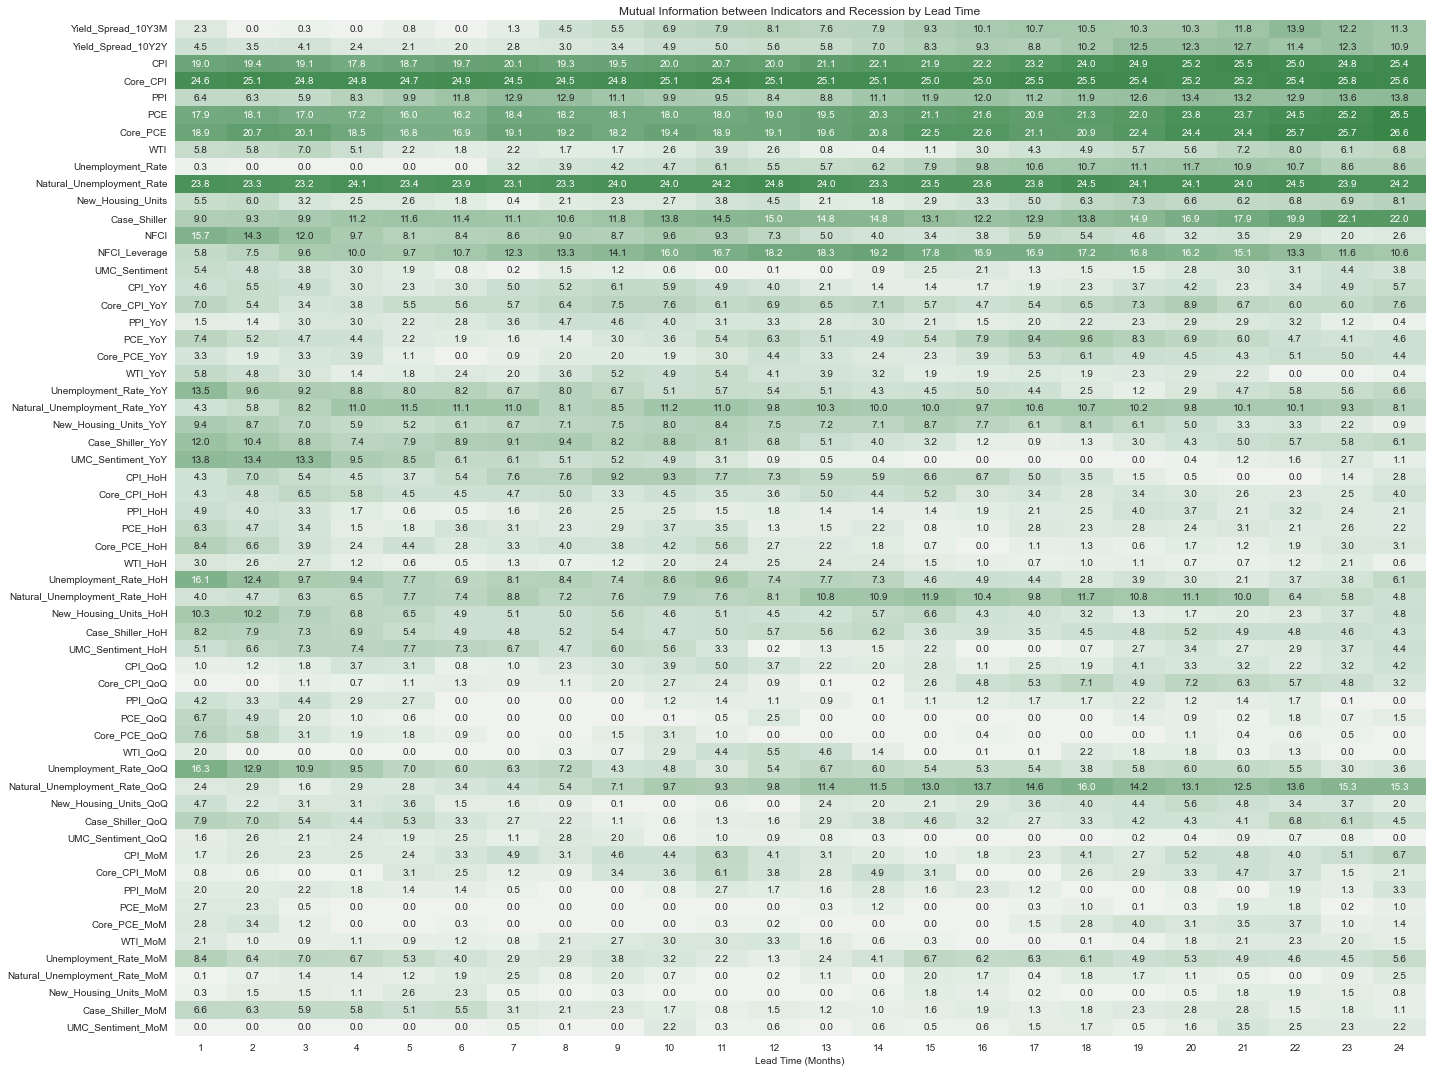

In [28]:
#### mutual information 계산
from sklearn.feature_selection import mutual_info_classif
mi = []
months = list(range(1, 25))
for month in months:
    df_ = data_resampled.copy()
    df_[label] = df_[label].shift(-month) # 해당시점으로부터 n개월 후의 경기침체 여부
    df_ = df_.dropna()
    # 해당시점으로부터 n개월 후의 경기침체 여부와 각 피처 사이의 mutual information
    mi.append(mutual_info_classif(df_.loc[:, features], df_[label], random_state=42))
mi = pd.DataFrame(mi, columns=features, index=months)
 
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(mi.T*100, cmap=cmap, center=0, ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Mutual Information between Indicators and Recession by Lead Time')
fig.tight_layout();

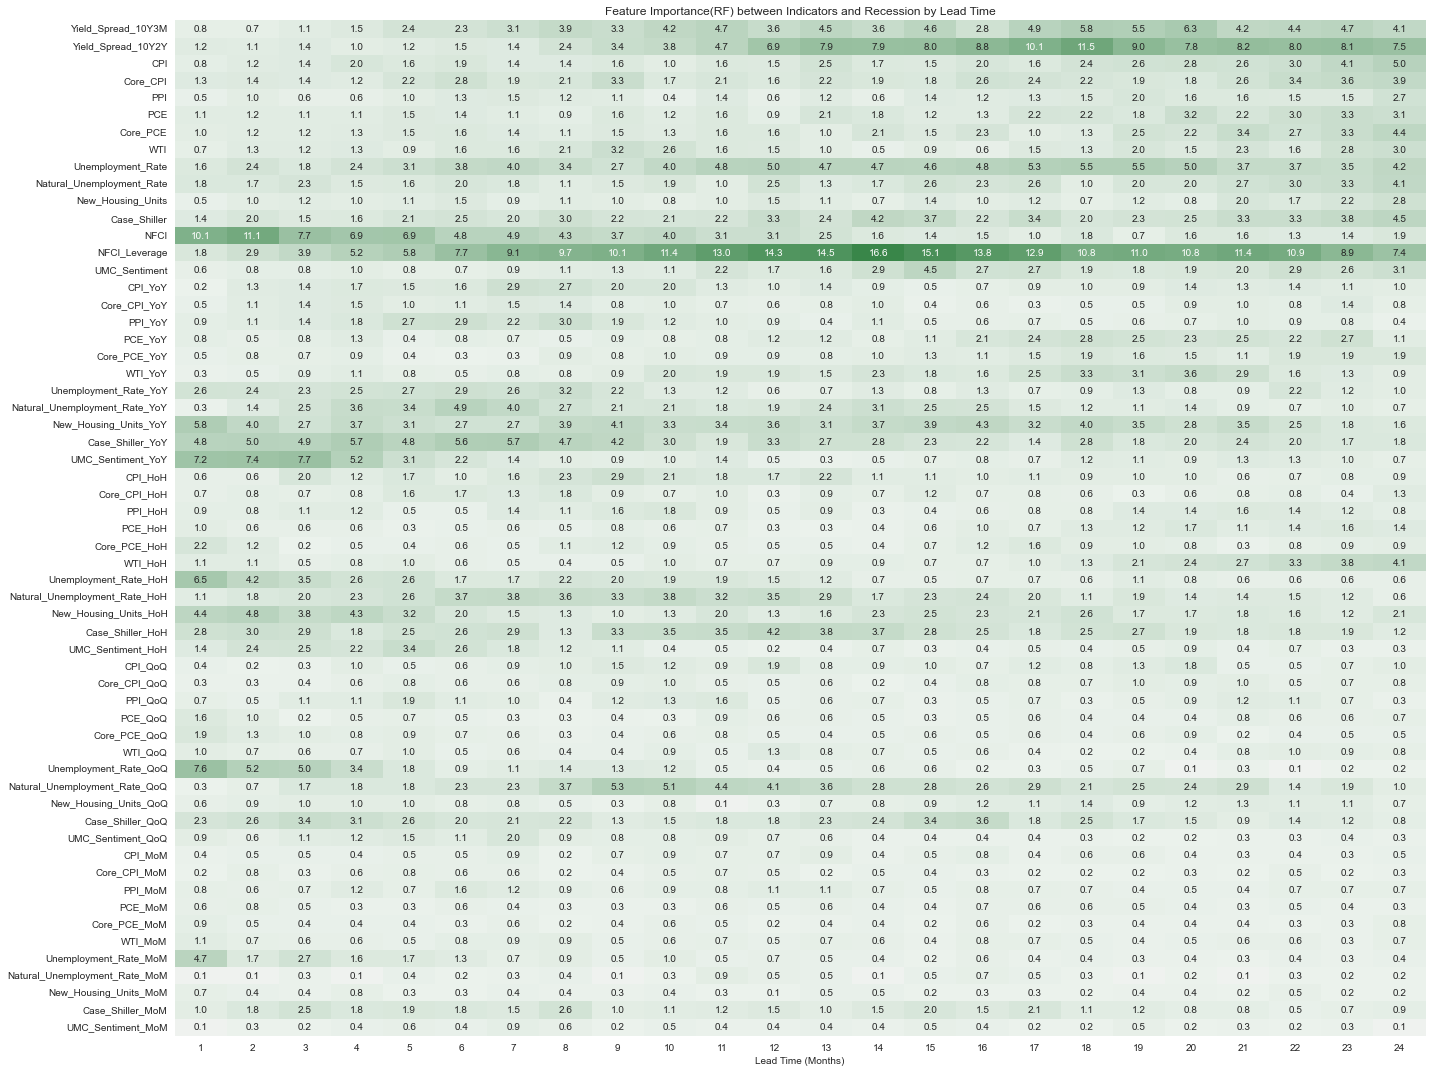

In [29]:
from sklearn.ensemble import RandomForestClassifier
#### feature importance 계산
imp = []
months = list(range(1, 25))
for month in months:
    df_ = data_resampled.copy()
    df_[label] = df_[label].shift(-month) # 해당시점으로부터 n개월 후의 경기침체 여부
    df_ = df_.dropna()
    # 해당시점으로부터 n개월 후의 경기침체 여부와 각 피처 사이의 feature importance
    model = RandomForestClassifier(n_estimators=100, random_state=42)
    model.fit(X=df_.loc[:, features], y=df_[label])
    imp.append(model.feature_importances_)
imp = pd.DataFrame(imp, columns=features, index=months)
 
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(imp.T*100, cmap=cmap, center=0, ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Feature Importance(RF) between Indicators and Recession by Lead Time')
fig.tight_layout();

In [30]:
from sklearn.model_selection import TimeSeriesSplit
 
tscv = TimeSeriesSplit(n_splits=3)
for i, (train_idx, valid_idx) in enumerate(tscv.split(df_.loc[:, features])):
    X_train = df_.iloc[train_idx, :][features]
    y_train = df_.iloc[train_idx, :][label]
    X_valid = df_.iloc[valid_idx, :][features]
    y_valid = df_.iloc[valid_idx, :][label]
    print(f'---------- {i+1}th split ----------')
    print(f"train start: {y_train.index[0].strftime('%Y-%m-%d')}, train end {y_train.index[-1].strftime('%Y-%m-%d')}, n_train: {X_train.shape[0]}, n_target_train: {y_train.sum()}")
    print(f"valid start: {y_valid.index[0].strftime('%Y-%m-%d')}, valid end {y_valid.index[-1].strftime('%Y-%m-%d')}, n_valid: {X_valid.shape[0]}, n_target_valid: {y_valid.sum()}")


---------- 1th split ----------
train start: 1988-01-31, train end 1996-04-30, n_train: 100, n_target_train: 8.0
valid start: 1996-05-31, valid end 2004-06-30, n_valid: 98, n_target_valid: 8.0
---------- 2th split ----------
train start: 1988-01-31, train end 2004-06-30, n_train: 198, n_target_train: 16.0
valid start: 2004-07-31, valid end 2012-08-31, n_valid: 98, n_target_valid: 18.0
---------- 3th split ----------
train start: 1988-01-31, train end 2012-08-31, n_train: 296, n_target_train: 34.0
valid start: 2012-09-30, valid end 2020-10-31, n_valid: 98, n_target_valid: 2.0


/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor o

/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor o

/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor o

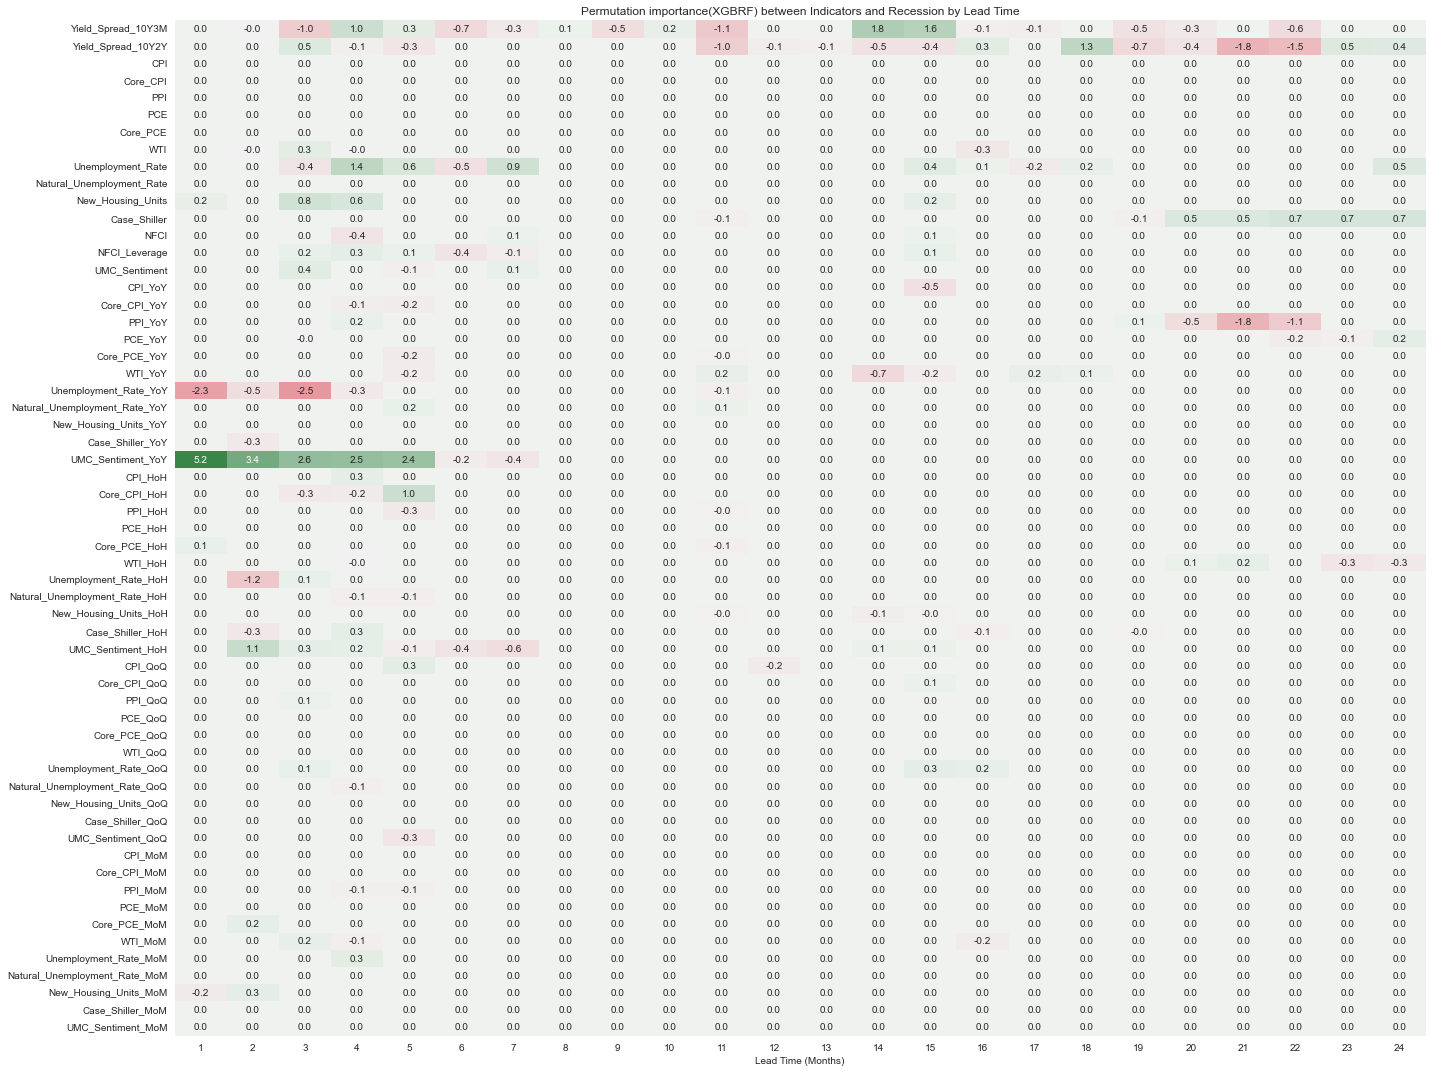

In [32]:
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBRFClassifier
 
permute_imp_XGBRF = []
auc_XGBRF = []
 
months = list(range(1, 25))
for month in months:
    df_ = data_resampled.copy()
    df_[label] = df_[label].shift(-month)
    df_ = df_.dropna()
 
    permute_imp_ = []
    auc_ = []
    
    tscv = TimeSeriesSplit(n_splits=3)
    for train_idx, valid_idx in tscv.split(df_.loc[:, features]):
 
        X_train = df_.iloc[train_idx, :][features]
        y_train = df_.iloc[train_idx, :][label]
        X_valid = df_.iloc[valid_idx, :][features]
        y_valid = df_.iloc[valid_idx, :][label]
        model = XGBRFClassifier(random_state=42)
        model.fit(X=X_train, y=y_train, eval_metric='auc')
        y_pred = model.predict_proba(X_valid)[:, 1]
        p_imp = permutation_importance(model, X_valid, y_valid,
                                       n_repeats=10,
                                       random_state=0)
        permute_imp_.append(p_imp['importances_mean'])
        auc_.append(roc_auc_score(y_valid, y_pred))
    permute_imp_XGBRF.append(np.mean(permute_imp_, axis=0))
    auc_XGBRF.append(np.mean(auc_, axis=0))
permute_imp_XGBRF = pd.DataFrame(permute_imp_XGBRF, columns=model.get_booster().feature_names, index=months)
 
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(permute_imp_XGBRF.T*100, cmap=cmap, center=0, ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Lead Time (Months)')
ax.set_title('Permutation importance(XGBRF) between Indicators and Recession by Lead Time')
fig.tight_layout();

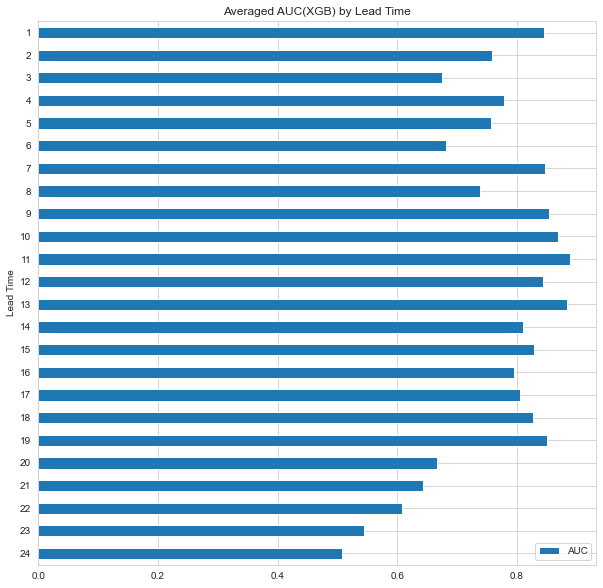

In [33]:
df_auc_XGB = pd.DataFrame(pd.concat([pd.Series([i+1 for i in range(24)], name='Lead Time'), 
                          pd.Series(auc_XGBRF, name='AUC')], axis=1))
df_auc_XGB.set_index('Lead Time').sort_index(ascending=False).plot.barh(
    figsize=(10, 10), 
    title='Averaged AUC(XGB) by Lead Time',
    ylabel='AUC',
    xlabel='Lead Time'
    );

In [34]:
def within_n_month_target(df, label, n):
    df = df.assign(
        target = df[label].shift(1).rolling(n).max().shift(-1).shift(-n).fillna(0)
    )
    return df
 
data_resampled = within_n_month_target(data_resampled, label, 12)
 
print(f'# of 1s in original target: {data_resampled[label].sum()}, # of 1s in new target: {data_resampled.target.sum()}')
 
# 새로 정의한 target(현재 시점 이후 1년내 경기침체가 발생하면 1 아니면 0)
label_new = 'target'

# of 1s in original target: 36.0, # of 1s in new target: 80.0


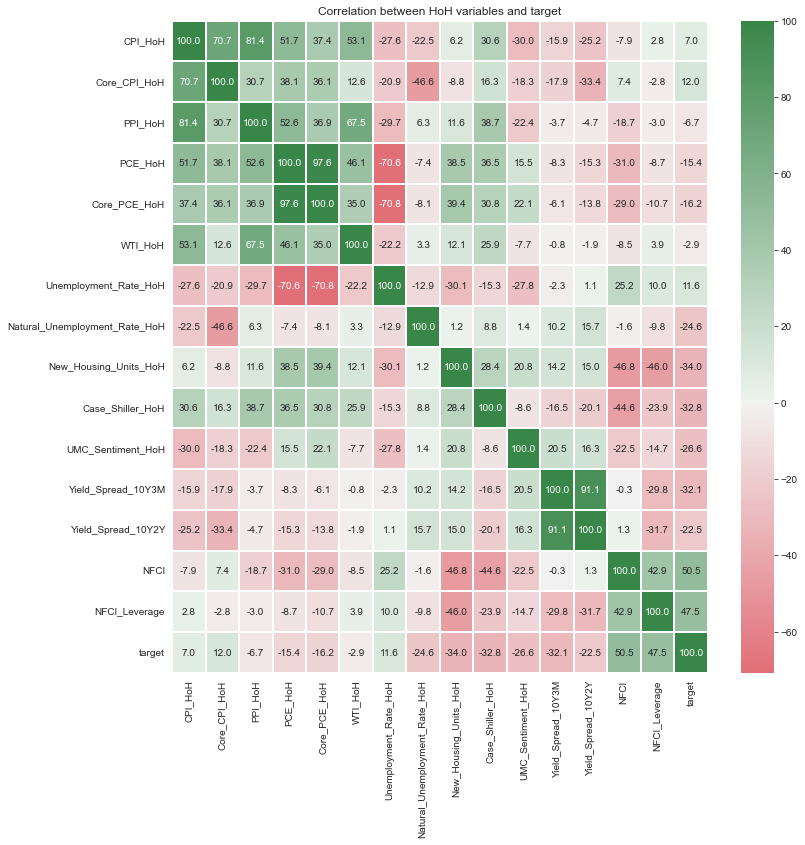

In [35]:
#Correlation between HoH variables
import seaborn as sns
import matplotlib.pyplot as plt
 
corr = data_resampled.loc[:,features_HoH+[label_new]].corr()*100
# ut = np.triu(corr)
cmap = sns.diverging_palette(10, 133, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))    # figsize
ax = sns.heatmap(corr,
                #  mask=ut,
                 cmap=cmap,           # cmap Color
                 annot=True,            # Value Text
                 fmt=".1f",             # Value type (interge = "d")
                 center=0.00,
                 linewidths=2)
ax.set_title(label=f'Correlation between HoH variables and target');

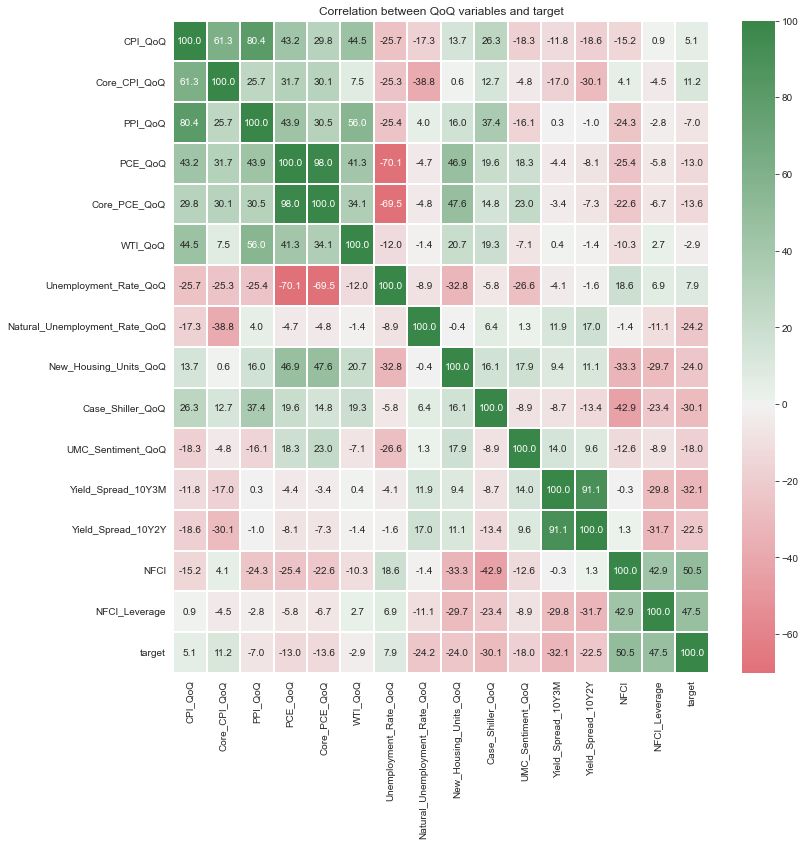

In [36]:
#Correlation between QoQ variables
import seaborn as sns
import matplotlib.pyplot as plt
 
corr = data_resampled.loc[:,features_QoQ+[label_new]].corr()*100
# ut = np.triu(corr)
cmap = sns.diverging_palette(10, 133, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))    # figsize
ax = sns.heatmap(corr,
                #  mask=ut,
                 cmap=cmap,           # cmap Color
                 annot=True,            # Value Text
                 fmt=".1f",             # Value type (interge = "d")
                 center=0.00,
                 linewidths=2)
ax.set_title(label=f'Correlation between QoQ variables and target');

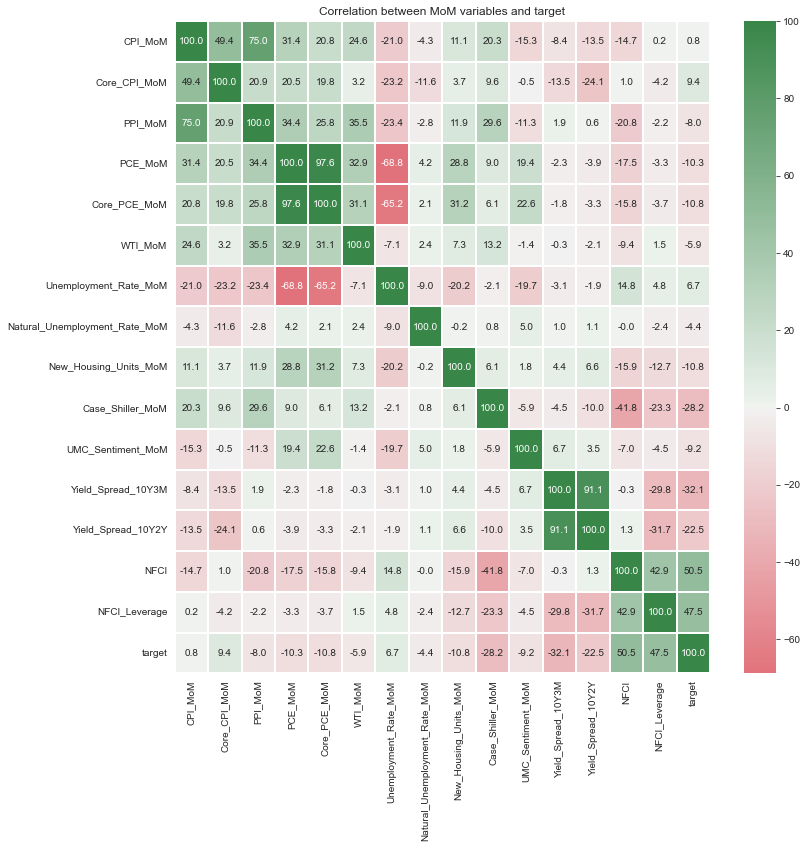

In [37]:
#Correlation between MoM variables
import seaborn as sns
import matplotlib.pyplot as plt
 
corr = data_resampled.loc[:,features_MoM+[label_new]].corr()*100
# ut = np.triu(corr)
cmap = sns.diverging_palette(10, 133, as_cmap=True)
fig, ax = plt.subplots(figsize=(12,12))    # figsize
ax = sns.heatmap(corr,
                #  mask=ut,
                 cmap=cmap,           # cmap Color
                 annot=True,            # Value Text
                 fmt=".1f",             # Value type (interge = "d")
                 center=0.00,
                 linewidths=2)
ax.set_title(label=f'Correlation between MoM variables and target');


In [38]:
# 전처리 작업 다시 수행
data_resampled = data.drop(columns=['Recession_GDP','Case_Shiller', 'WTI']).ffill().resample('M').last()
 
data_resampled = data_resampled.assign(
 
    CPI_YoY=data_resampled.CPI.pct_change(12),
    Core_CPI_YoY=data_resampled.Core_CPI.pct_change(12),
    PPI_YoY=data_resampled.PPI.pct_change(12),
    PCE_YoY=data_resampled.PCE.pct_change(12),
    Core_PCE_YoY=data_resampled.Core_PCE.pct_change(12),
    Unemployment_Rate_YoY=data_resampled.Unemployment_Rate.pct_change(12),
    Natural_Unemployment_Rate_YoY=data_resampled.Natural_Unemployment_Rate.pct_change(12),
    New_Housing_Units_YoY=data_resampled.New_Housing_Units.pct_change(12),
    UMC_Sentiment_YoY=data_resampled.UMC_Sentiment.pct_change(12),
 
    CPI_HoH=data_resampled.CPI.pct_change(6),
    Core_CPI_HoH=data_resampled.Core_CPI.pct_change(6),
    PPI_HoH=data_resampled.PPI.pct_change(6),
    PCE_HoH=data_resampled.PCE.pct_change(6),
    Core_PCE_HoH=data_resampled.Core_PCE.pct_change(6),
    Unemployment_Rate_HoH=data_resampled.Unemployment_Rate.pct_change(6),
    Natural_Unemployment_Rate_HoH=data_resampled.Natural_Unemployment_Rate.pct_change(6),
    New_Housing_Units_HoH=data_resampled.New_Housing_Units.pct_change(6),
    UMC_Sentiment_HoH=data_resampled.UMC_Sentiment.pct_change(6),
 
    CPI_QoQ=data_resampled.CPI.pct_change(3),
    Core_CPI_QoQ=data_resampled.Core_CPI.pct_change(3),
    PPI_QoQ=data_resampled.PPI.pct_change(3),
    PCE_QoQ=data_resampled.PCE.pct_change(3),
    Core_PCE_QoQ=data_resampled.Core_PCE.pct_change(3),
    Unemployment_Rate_QoQ=data_resampled.Unemployment_Rate.pct_change(3),
    Natural_Unemployment_Rate_QoQ=data_resampled.Natural_Unemployment_Rate.pct_change(3),
    New_Housing_Units_QoQ=data_resampled.New_Housing_Units.pct_change(3),
    UMC_Sentiment_QoQ=data_resampled.UMC_Sentiment.pct_change(3),
 
    CPI_MoM=data_resampled.CPI.pct_change(1),
    Core_CPI_MoM=data_resampled.Core_CPI.pct_change(1),
    PPI_MoM=data_resampled.PPI.pct_change(1),
    PCE_MoM=data_resampled.PCE.pct_change(1),
    Core_PCE_MoM=data_resampled.Core_PCE.pct_change(1),
    Unemployment_Rate_MoM=data_resampled.Unemployment_Rate.pct_change(1),
    Natural_Unemployment_Rate_MoM=data_resampled.Natural_Unemployment_Rate.pct_change(1),
    New_Housing_Units_MoM=data_resampled.New_Housing_Units.pct_change(1),
    UMC_Sentiment_MoM=data_resampled.UMC_Sentiment.pct_change(1)
                                       )
 
data_resampled = data_resampled.dropna()
 
def within_n_month_target(df, label, n):
    df = df.assign(
        target = df[label].shift(1).rolling(n).max().shift(-1).shift(-n).fillna(0)
    )
    return df
 
data_resampled = within_n_month_target(data_resampled, label, 12)
 
label = 'Recession_NBER'
label_new = 'target'
features = [col for col in data_resampled.columns if col not in [label, label_new]] 
 
data_resampled.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 490 entries, 1982-01-31 to 2022-10-31
Freq: M
Data columns (total 51 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   Recession_NBER                 490 non-null    float64
 1   Yield_Spread_10Y3M             490 non-null    float64
 2   Yield_Spread_10Y2Y             490 non-null    float64
 3   CPI                            490 non-null    float64
 4   Core_CPI                       490 non-null    float64
 5   PPI                            490 non-null    float64
 6   PCE                            490 non-null    float64
 7   Core_PCE                       490 non-null    float64
 8   Unemployment_Rate              490 non-null    float64
 9   Natural_Unemployment_Rate      490 non-null    float64
 10  New_Housing_Units              490 non-null    float64
 11  NFCI                           490 non-null    float64
 12  NFCI_Leverage          

/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(
/Users/kimtaeyeong/opt/anaconda3/lib/python3.9/site-packages/xgboost/sklearn.py:861: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor o

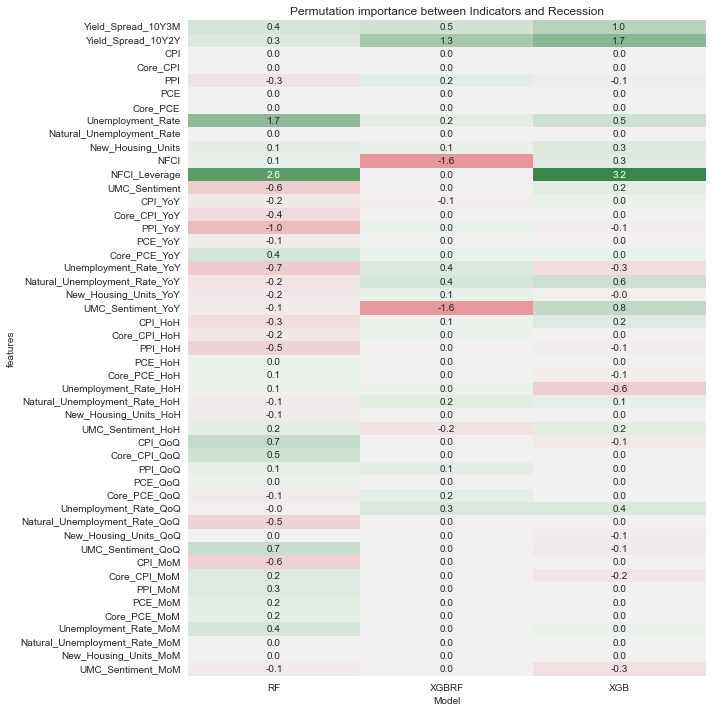

In [46]:
#### Random Forest 
from sklearn.ensemble import RandomForestClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score

df_ = data_resampled.copy()

permute_imp_ = []
auc_ = []
tscv = TimeSeriesSplit(n_splits=3)
for train_idx, valid_idx in tscv.split(df_.loc[:, features]):
 
    X_train = df_.iloc[train_idx, :][features]
    y_train = df_.iloc[train_idx, :][label_new]
    X_valid = df_.iloc[valid_idx, :][features]
    y_valid = df_.iloc[valid_idx, :][label_new]
    model = RandomForestClassifier(random_state=42)
    model.fit(X=X_train, y=y_train)
    y_pred = model.predict_proba(X_valid)[:, 1]
    p_imp = permutation_importance(model, X_valid, y_valid,
                                    n_repeats=10,
                                    random_state=0)
    permute_imp_.append(p_imp['importances_mean'])
    auc_.append(roc_auc_score(y_valid, y_pred))

permute_imp_rf = np.mean(permute_imp_, axis=0)
auc_rf = np.mean(auc_, axis=0)
df_permute_imp_rf = pd.DataFrame({'features':features, 'RF': permute_imp_rf})
 
#### XGBRF
from xgboost import XGBRFClassifier
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import roc_auc_score
 
permute_imp_ = []
auc_ = []
tscv = TimeSeriesSplit(n_splits=3)
for train_idx, valid_idx in tscv.split(df_.loc[:, features]):
 
    X_train = df_.iloc[train_idx, :][features]
    y_train = df_.iloc[train_idx, :][label_new]
    X_valid = df_.iloc[valid_idx, :][features]
    y_valid = df_.iloc[valid_idx, :][label_new]
    model = XGBRFClassifier(random_state=42)
    model.fit(X=X_train, y=y_train, eval_metric='auc')
    y_pred = model.predict_proba(X_valid)[:, 1]
    p_imp = permutation_importance(model, X_valid, y_valid,
                                    n_repeats=10,
                                    random_state=0)
    permute_imp_.append(p_imp['importances_mean'])
    auc_.append(roc_auc_score(y_valid, y_pred))

permute_imp_XGBRF = np.mean(permute_imp_, axis=0)
auc_XGBRF = np.mean(auc_, axis=0)
df_permute_imp_XGBRF = pd.DataFrame({'features':model.get_booster().feature_names, 'XGBRF': permute_imp_XGBRF})
 

#### XGB
from sklearn.inspection import permutation_importance
from sklearn.model_selection import TimeSeriesSplit
from xgboost import XGBClassifier
 
permute_imp_ = []
auc_ = []
 
tscv = TimeSeriesSplit(n_splits=3)
for train_idx, valid_idx in tscv.split(df_.loc[:, features]):
 
    X_train = df_.iloc[train_idx, :][features]
    y_train = df_.iloc[train_idx, :][label_new]
    X_valid = df_.iloc[valid_idx, :][features]
    y_valid = df_.iloc[valid_idx, :][label_new]
    model = XGBClassifier(random_state=42)
    model.fit(X=X_train, y=y_train, eval_metric='auc')
    y_pred = model.predict_proba(X_valid)[:, 1]
 
    p_imp = permutation_importance(model, X_valid, y_valid,
                                    n_repeats=10,
                                    random_state=0)
    permute_imp_.append(p_imp['importances_mean'])
    auc_.append(roc_auc_score(y_valid, y_pred))
permute_imp_XGB = np.mean(permute_imp_, axis=0)
auc_XGB = np.mean(auc_, axis=0)
df_permute_imp_XGB = pd.DataFrame({'features':model.get_booster().feature_names, 'XGB': permute_imp_XGB})

df_permute_imp = pd.concat([
    df_permute_imp_rf.set_index('features'),
    df_permute_imp_XGBRF.set_index('features'),
    df_permute_imp_XGB.set_index('features')
    ]
    ,axis=1
    )
    
fig, ax = plt.subplots(figsize=(10, 10))
cmap = sns.diverging_palette(10, 133, as_cmap=True)
sns.heatmap(df_permute_imp*100, cmap=cmap, center=0, ax=ax, annot=True, fmt='.1f', cbar=False)
ax.set_xlabel('Model')
ax.set_title('Permutation importance between Indicators and Recession')
fig.tight_layout();

In [47]:
print(f'''AUC(RF): {round(auc_rf, 4)}, 
AUC(XGBRF): {round(auc_XGBRF, 4)}, 
AUC(XGB): {round(auc_XGB, 4)}''')

AUC(RF): 0.8228, 
AUC(XGBRF): 0.7434, 
AUC(XGB): 0.887


In [70]:
X_train = data_resampled[:'2020-12-31'][features]
y_train = data_resampled[:'2020-12-31'][label_new]
X_test = data_resampled['2021-01-31':'2021-12-31'][features]
 
model = XGBClassifier(random_state=42)
model.fit(X=X_train, y=y_train, eval_metric='auc')
 
pred = pd.DataFrame({'Date': X_test.index.strftime('%Y%m'), 'Recession prob.': model.predict_proba(X_test)[:,1]})
import plotly.express as px
fig = px.line(pred, x='Date', y='Recession prob.')
fig.update_layout(title='Recession prob. within 12 months', title_x=0.5)
pred.to_excel(excel_writer='20210131~20211231.xlsx')